# Variational Autoencoders
Variational autoencoders (VAE) are a powerful and widely-used class of models to learn complex data distributions in an unsupervised fashion.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/MNIST_data')

Extracting /tmp/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [4]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 16#16#

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2
print('49 * {} // 2 = {}'.format(dec_in_channels,inputs_decoder ))

49 * 1 // 2 = 24


###  Defining the encoder
What's most noteworthy is the fact that we are creating two vectors in our encoder, as the encoder is supposed to create objects following a Gaussian Distribution:
* A vector of means
* A vector of standard deviations

You will see later how we "force" the encoder to make sure it really creates values following a Normal Distribution. The returned values that will be fed to the decoder are the z-values. We will need the mean and standard deviation of our distributions later, when computing losses.

In [5]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(x.shape) #(?, 14, 14, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(x.shape) #(?, 7, 7, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        print(x.shape) #(?, 7, 7, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        print(x.shape) #(?, 3136)

        mn = tf.layers.dense(x, units=n_latent) # units: Integer or Long, dimensionality of the output space.
        print(mn.shape) #(?, 8)
        sd = 0.5 * tf.layers.dense(x, units=n_latent) 
        print(sd.shape) #(?, 8)
        
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        print(epsilon.shape) #(?, 8)
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        print(z.shape) #(?, 8)
        return z, mn, sd

In [6]:
print('X_in : ', X_in.shape)
sampled, mn, sd = encoder(X_in, keep_prob)
print(sampled.shape) #(?, 8)
print(sampled)

X_in :  (?, 28, 28)
(?, 14, 14, 64)
(?, 7, 7, 64)
(?, 7, 7, 64)
(?, 3136)
(?, 16)
(?, 16)
(?, 16)
(?, 16)
(?, 16)
Tensor("encoder/add:0", shape=(?, 16), dtype=float32)


### Defining the decoder
The decoder **does not** care about whether the input values are sampled from some specific distribution that has been defined by us. It simply will try to reconstruct the input images. To this end, we use a series of transpose convolutions.

In [7]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        print(x.shape) #(?, 24)
        #x = tf.layers.dense(sampled_z, inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        print(x.shape) #(?, 49)
        x = tf.reshape(x, reshaped_dim)
        print(x.shape) #(?, 7, 7, 1)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        print(x.shape) #(?, 14, 14, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        print(x.shape) #(?, 14, 14, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        print(x.shape) #(?, 14, 14, 64)
        
        x = tf.contrib.layers.flatten(x)
        print(x.shape) #(?, 12544)
        
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        print(x.shape) #(?, 784)
        
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

Now, we'll wire together both parts:

In [8]:
dec = decoder(sampled, keep_prob)

(?, 24)
(?, 49)
(?, 7, 7, 1)
(?, 14, 14, 64)
(?, 14, 14, 64)
(?, 14, 14, 64)
(?, 12544)
(?, 784)


### Computing losses and enforcing a Gaussian latent distribution
For computing the image reconstruction loss, we simply use squared difference (which could lead to images sometimes looking a bit fuzzy). This loss is combined with the Kullback-Leibler divergence, which makes sure our latent values will be sampled from a normal distribution. For more on this topic, please take a look a Jaan Altosaar's great article on VAEs.

In [9]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)


In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Training the network

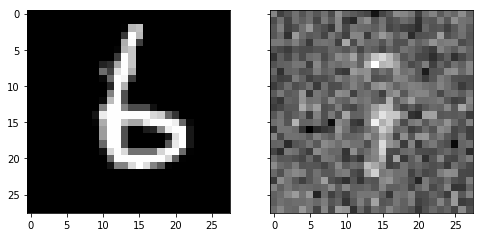

0 177.55063 177.54613 0.0045195115


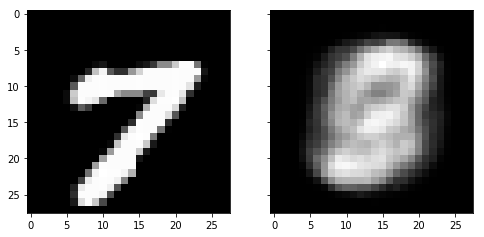

200 49.923782 47.611225 2.3125556


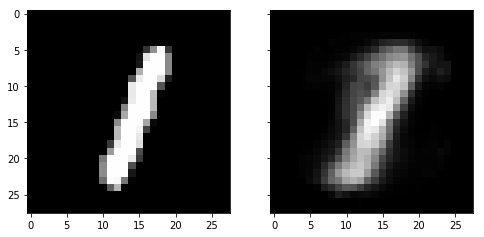

400 40.987457 35.281994 5.705464


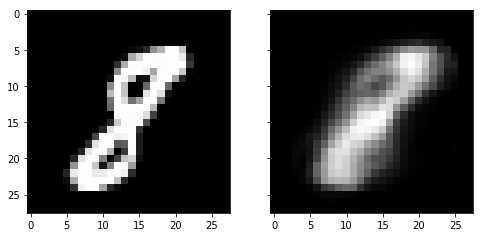

600 37.4946 29.943863 7.5507383


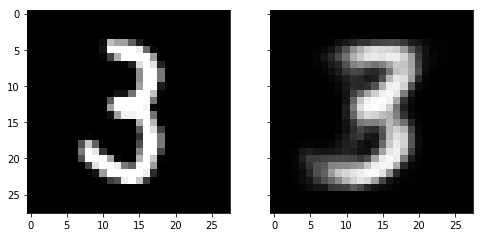

800 35.46988 26.454844 9.015036


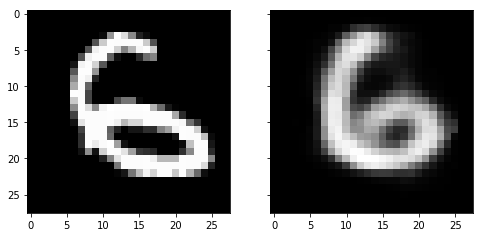

1000 33.88391 25.44049 8.443419


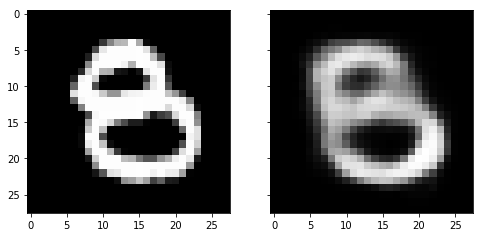

1200 33.382206 23.538721 9.843485


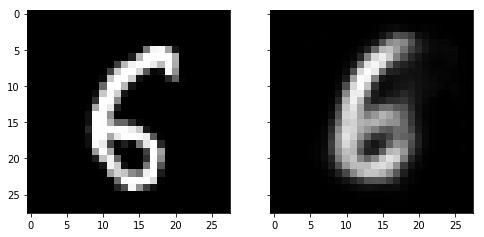

1400 34.790413 25.314026 9.476385


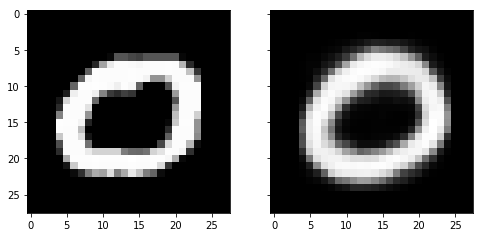

1600 32.721836 22.500717 10.221121


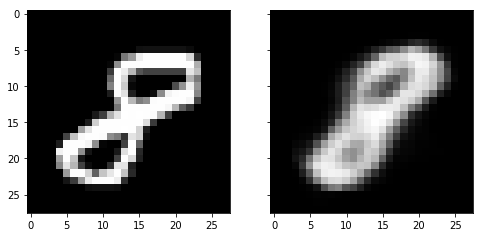

1800 32.487167 22.607418 9.879747


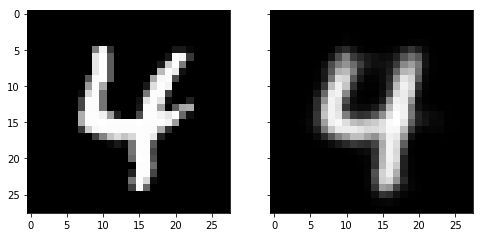

2000 28.787888 19.122128 9.665761


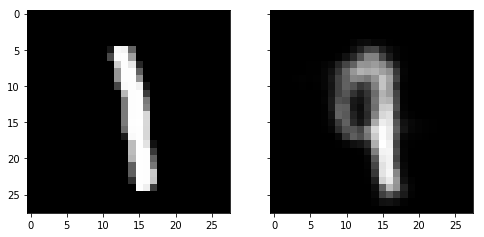

2200 30.093876 20.53219 9.5616865


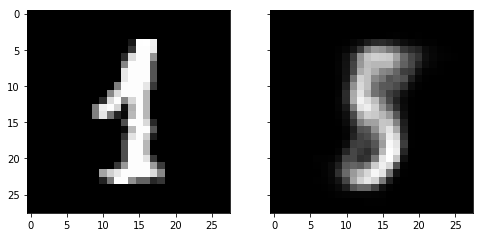

2400 30.4352 20.499596 9.935604


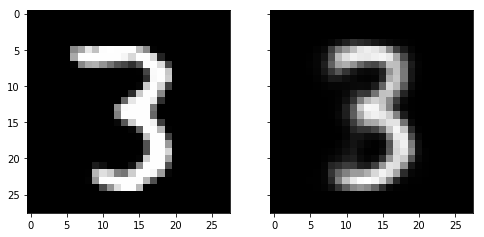

2600 31.78601 21.189571 10.59644


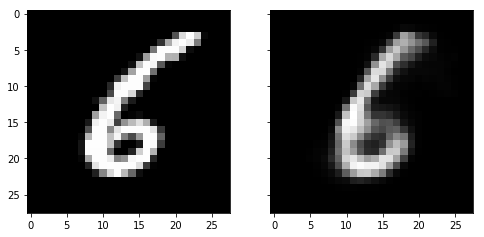

2800 27.930851 18.313726 9.617126


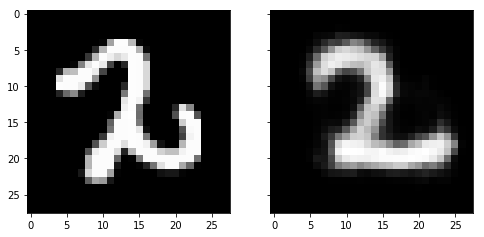

3000 32.22977 21.479393 10.750379


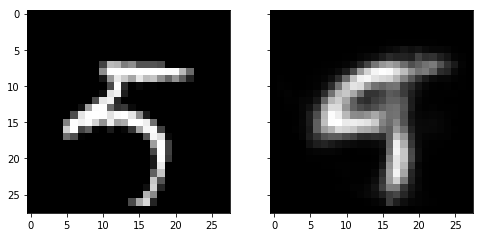

3200 31.307888 20.75504 10.552849


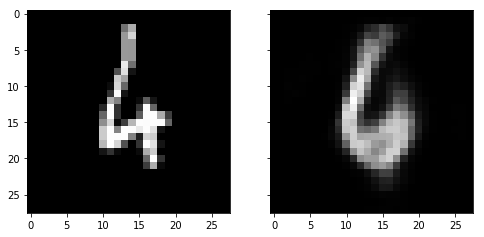

3400 31.006138 20.422838 10.583299


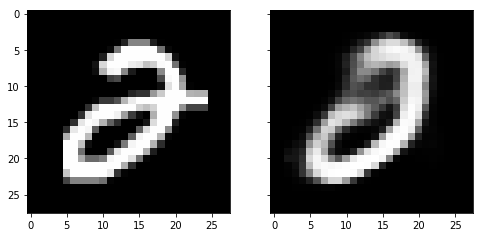

3600 29.20098 18.630402 10.570577


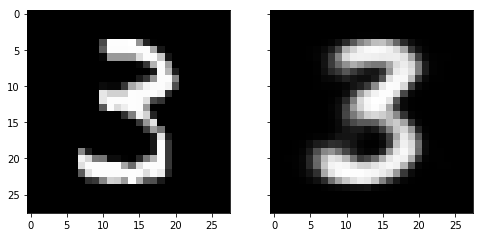

3800 28.5588 18.301247 10.257552


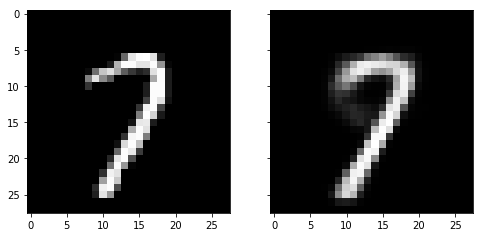

4000 29.028328 18.461145 10.567184


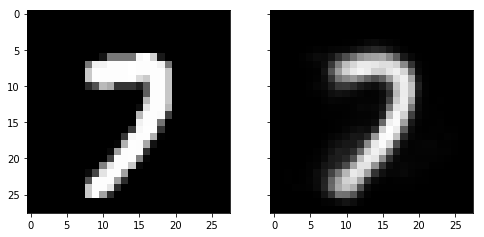

4200 26.480171 16.269798 10.210375


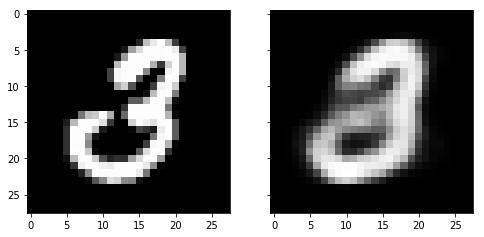

4400 30.184494 19.591343 10.593149


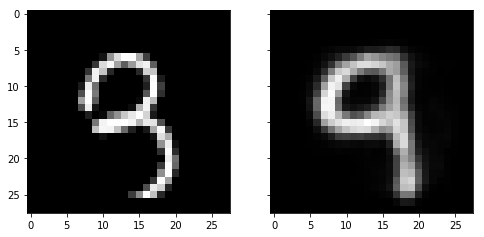

4600 30.215397 19.467829 10.747568


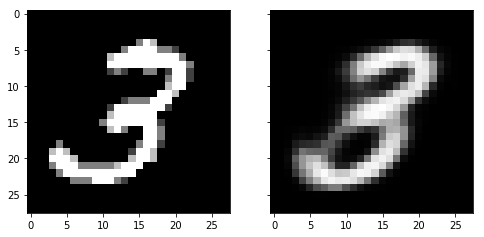

4800 29.135553 18.247717 10.887837


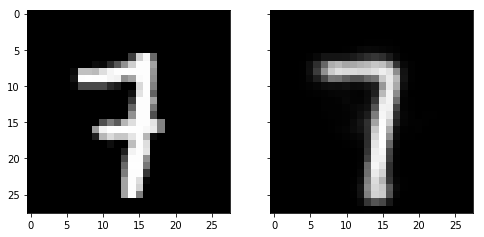

5000 29.08062 18.807964 10.2726555


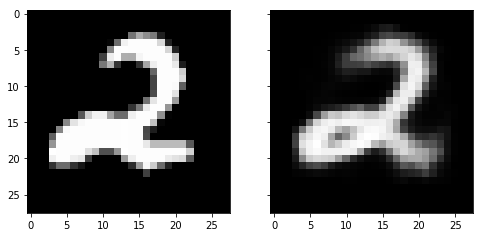

5200 28.794134 17.62123 11.172904


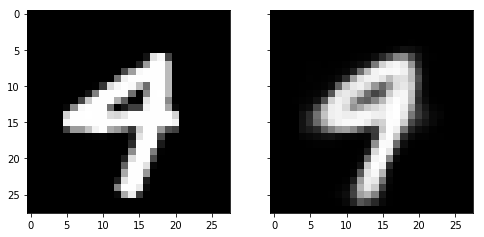

5400 31.473747 20.117325 11.356423


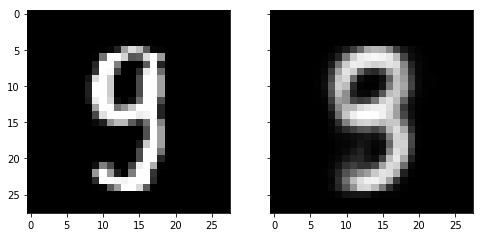

5600 31.504278 19.955976 11.548301


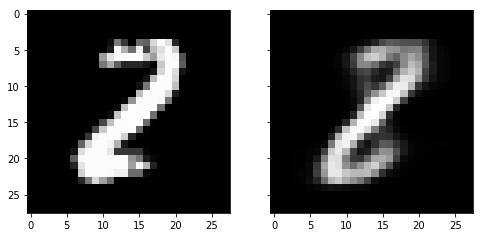

5800 29.12374 18.428232 10.695507


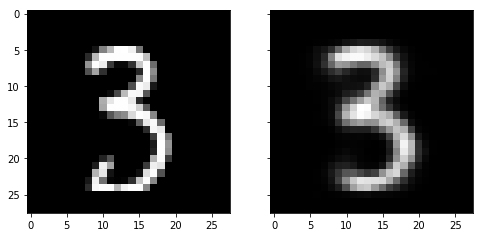

6000 30.374687 19.673012 10.701675


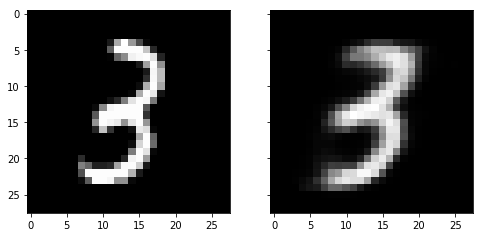

6200 29.347536 18.480259 10.867277


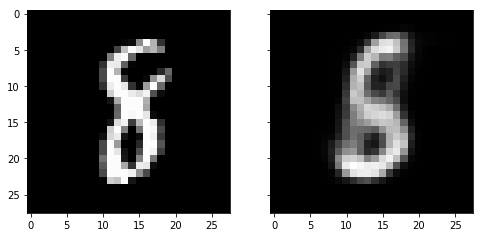

6400 29.240198 18.279284 10.960913


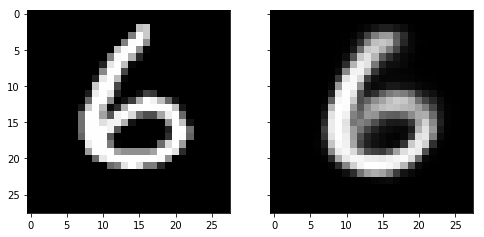

6600 28.627144 17.542786 11.084358


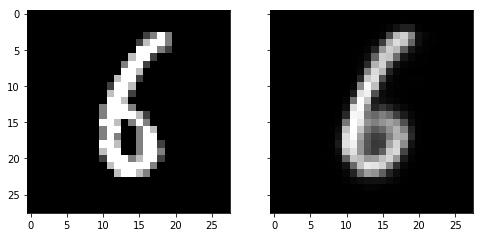

6800 28.496143 17.274185 11.221956


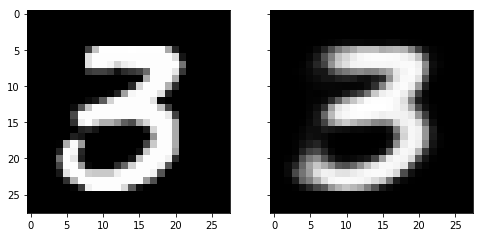

7000 29.36826 17.644447 11.72381


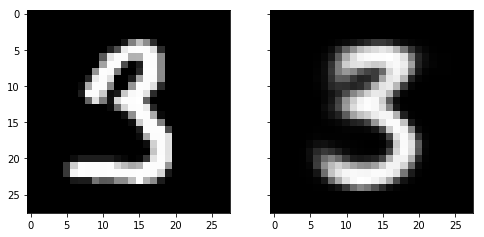

7200 26.649094 15.958322 10.69077


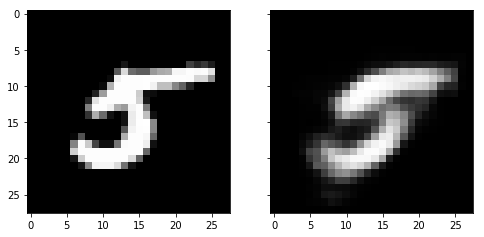

7400 28.644611 17.10648 11.538133


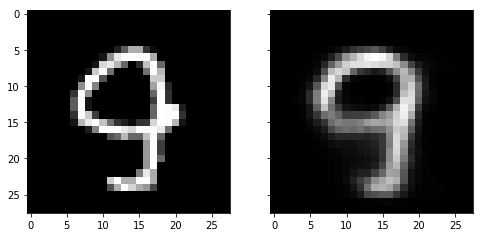

7600 28.395847 17.486897 10.908953


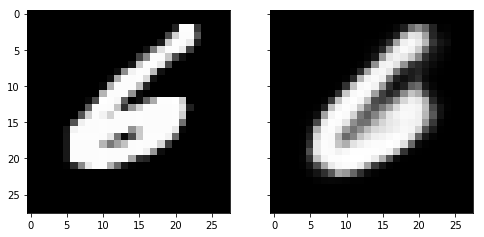

7800 26.940416 16.119083 10.821331


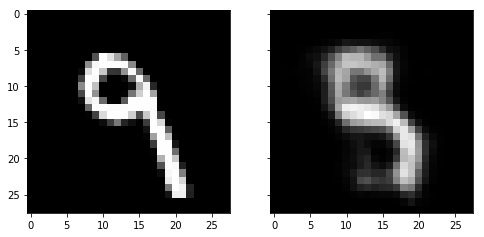

8000 27.661621 17.6013 10.06032


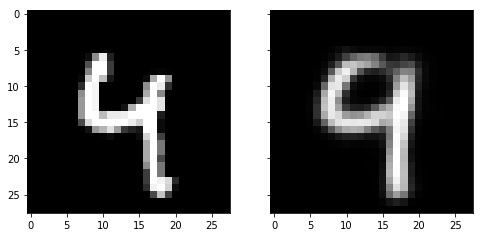

8200 26.733166 15.722303 11.010862


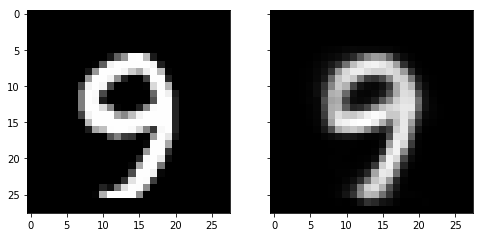

8400 27.557877 16.229918 11.327961


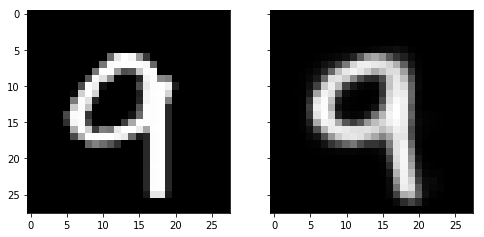

8600 25.500736 15.483134 10.017602


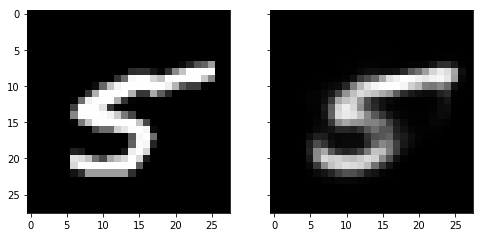

8800 29.07885 17.70546 11.373392


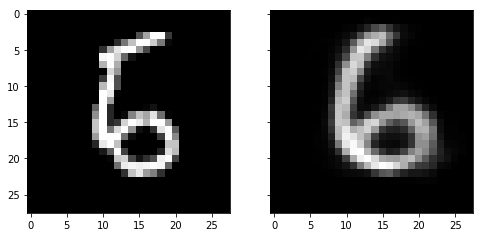

9000 29.751127 18.574636 11.176492


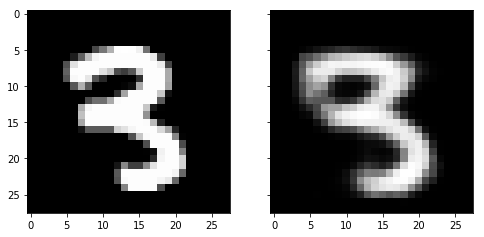

9200 27.505398 15.975061 11.530338


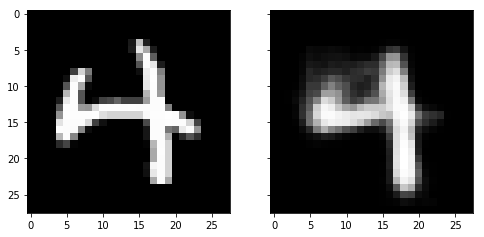

9400 29.166897 17.780397 11.3864975


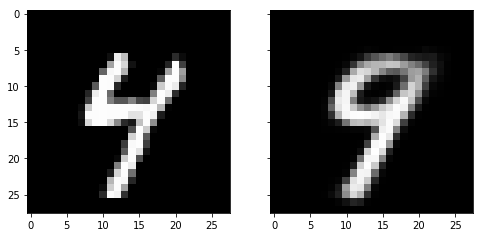

9600 27.99974 16.688368 11.311371


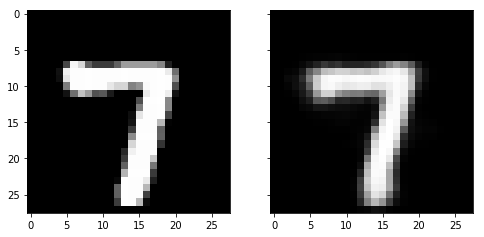

9800 27.216967 15.322002 11.894964


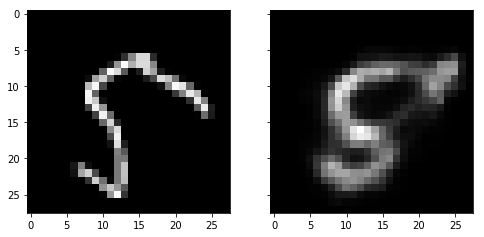

10000 31.400333 19.351156 12.04918


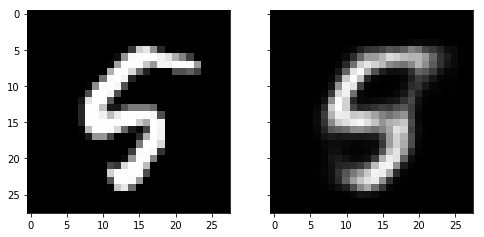

10200 27.111279 16.480644 10.630632


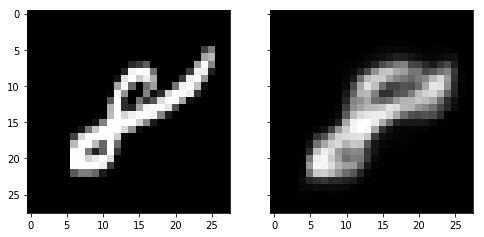

10400 26.451633 15.256661 11.194971


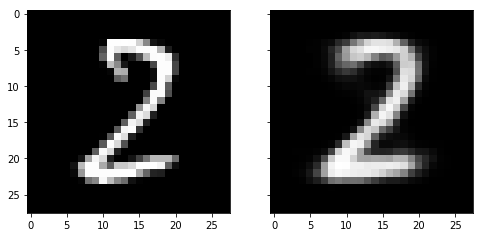

10600 27.301672 15.645263 11.656408


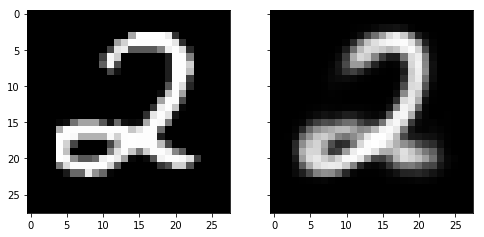

10800 26.276787 15.256925 11.019861


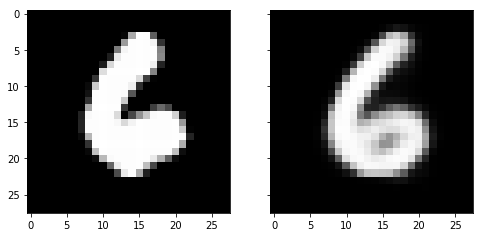

11000 27.804976 16.459448 11.345528


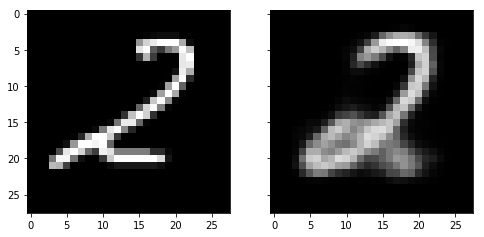

11200 28.172619 16.594858 11.577762


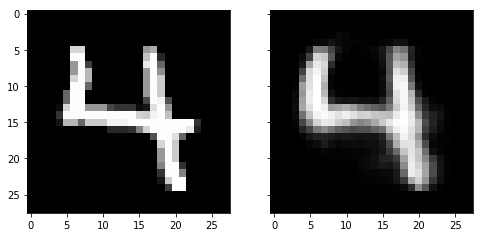

11400 26.93512 16.039017 10.896103


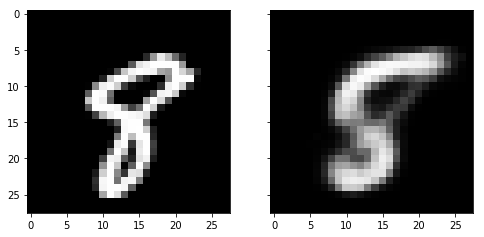

11600 30.424572 18.72607 11.6985


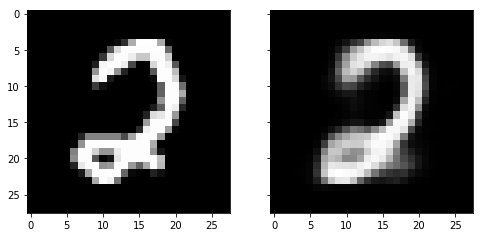

11800 29.02636 17.00833 12.018032


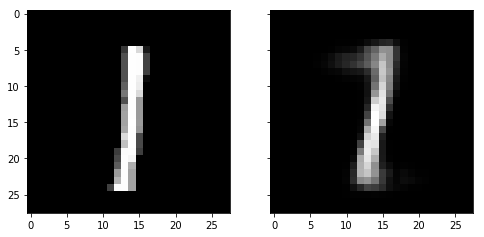

12000 26.829441 15.6348505 11.1945915


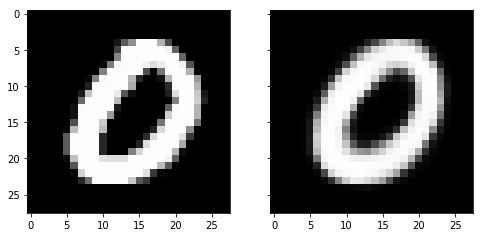

12200 27.89682 16.657455 11.239365


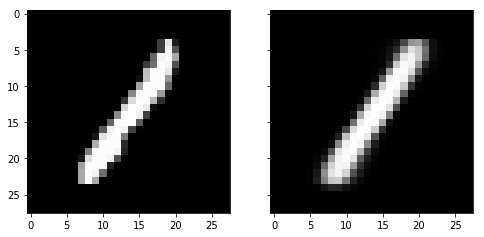

12400 27.979294 16.404531 11.574761


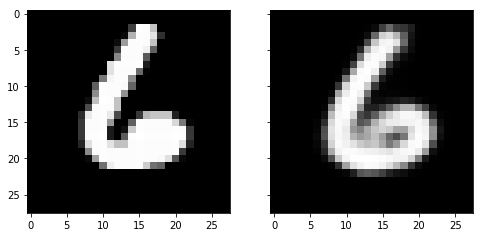

12600 26.574726 15.403502 11.171225


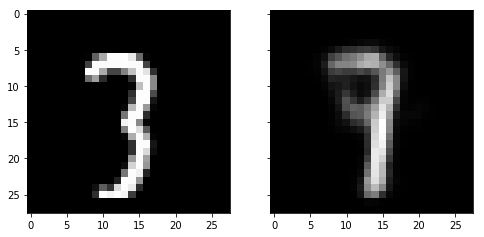

12800 28.135208 16.937649 11.197561


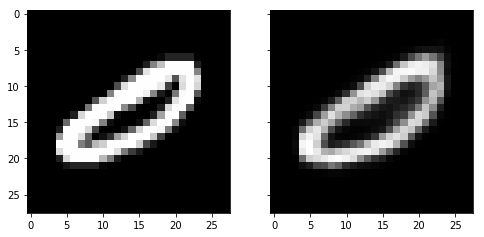

13000 27.521908 16.429413 11.092493


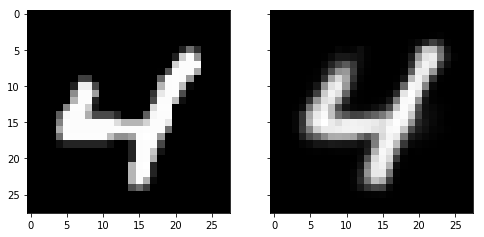

13200 26.719444 15.432215 11.2872305


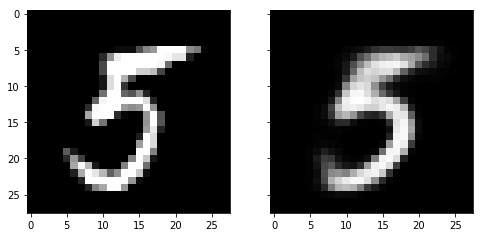

13400 27.074036 15.232845 11.841191


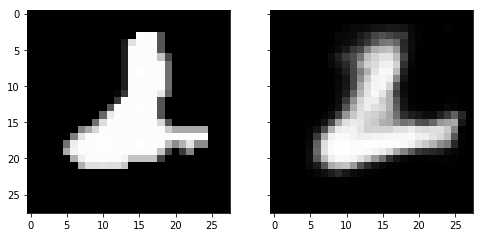

13600 24.92416 14.367289 10.556871


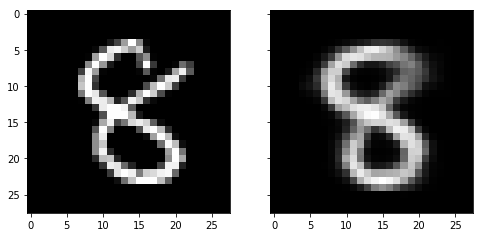

13800 27.475245 16.223469 11.251776


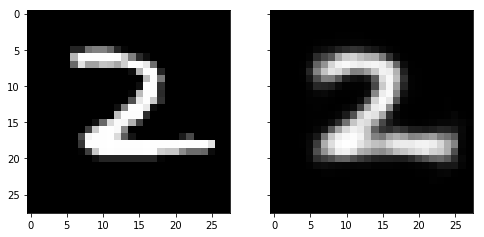

14000 29.031628 17.219597 11.812031


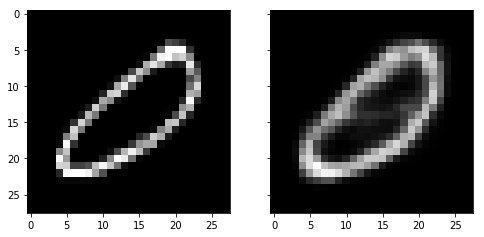

14200 27.754349 15.966849 11.787499


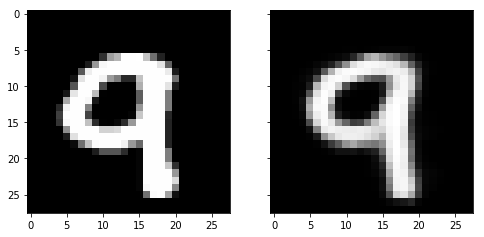

14400 26.71065 15.5759735 11.134676


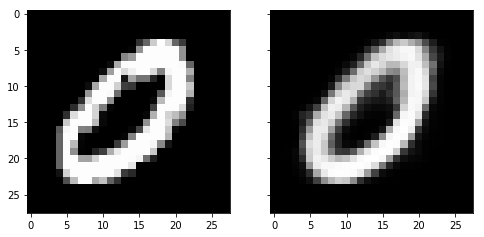

14600 26.733969 15.189896 11.544073


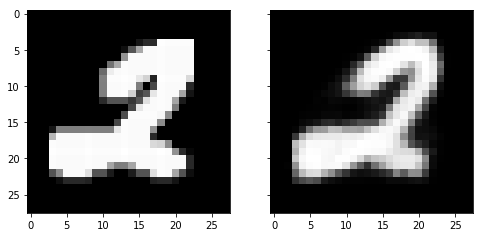

14800 27.579536 15.0742655 12.505273


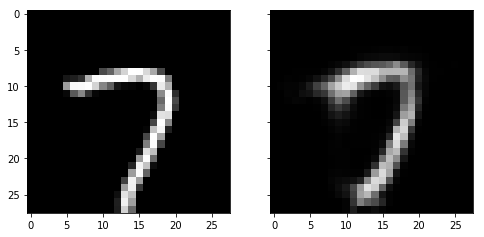

15000 26.289402 15.013434 11.275967


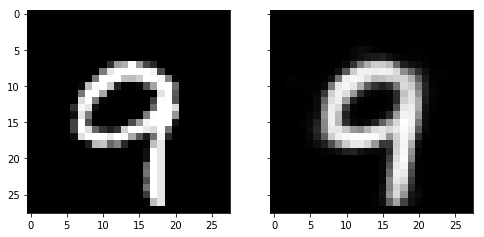

15200 27.997877 16.120714 11.877163


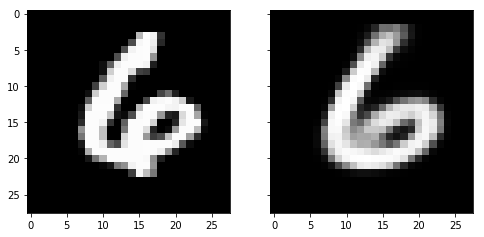

15400 27.937792 16.052683 11.885109


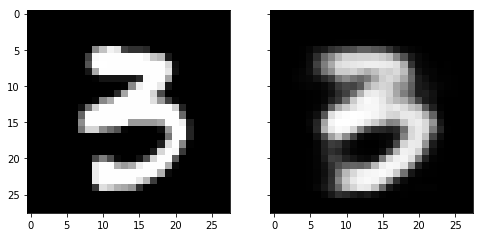

15600 26.655533 15.127294 11.52824


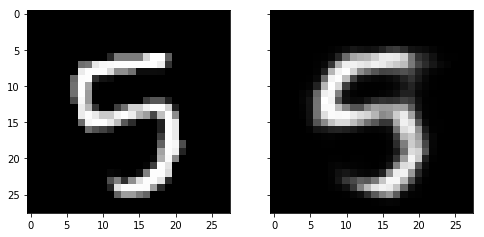

15800 27.203123 15.43236 11.770763


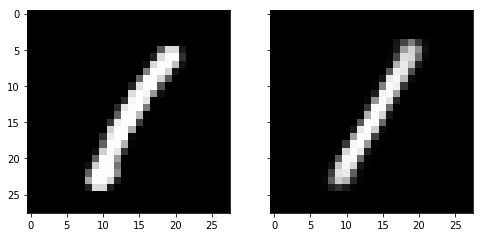

16000 26.21531 14.356145 11.859164


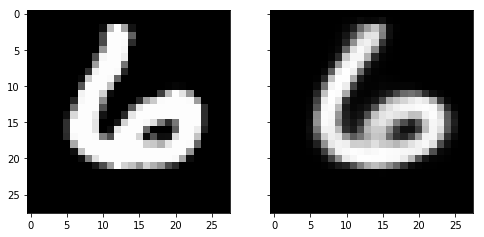

16200 27.20671 15.227278 11.979432


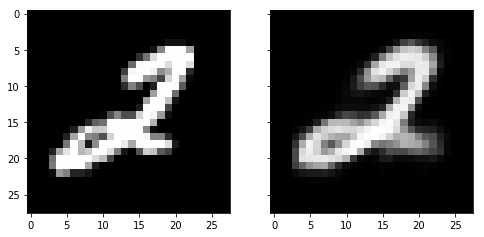

16400 27.305058 15.361272 11.943787


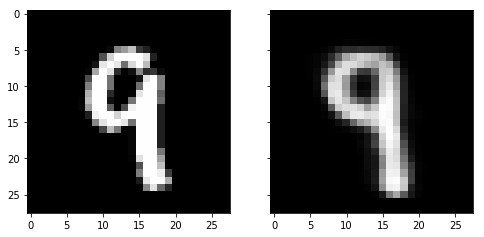

16600 27.187737 15.205332 11.982405


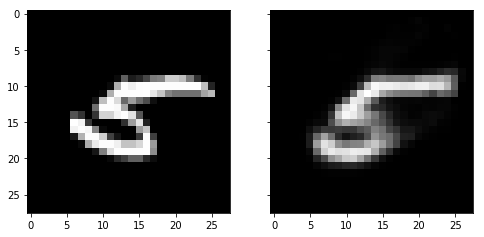

16800 26.762373 15.172058 11.590315


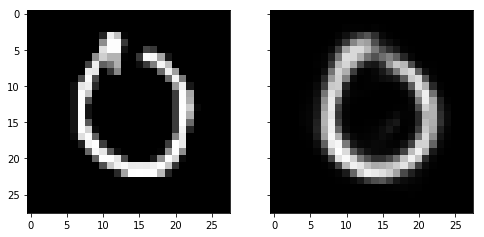

17000 27.605349 14.633047 12.9723


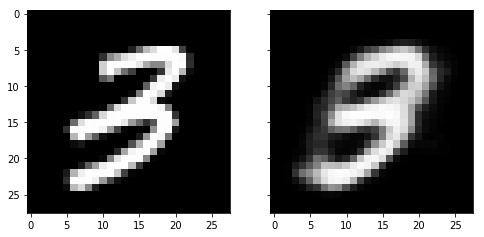

17200 25.830702 14.679343 11.15136


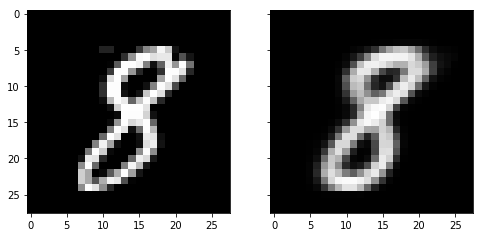

17400 25.984873 14.590015 11.394859


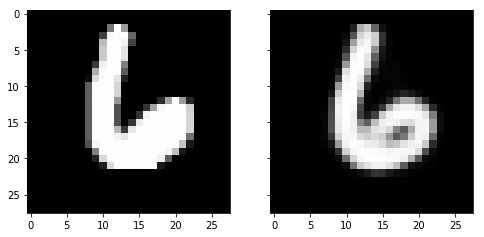

17600 25.603327 14.036211 11.567116


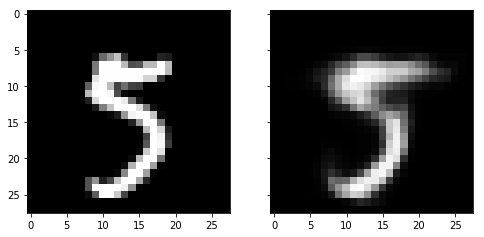

17800 27.222456 16.082415 11.14004


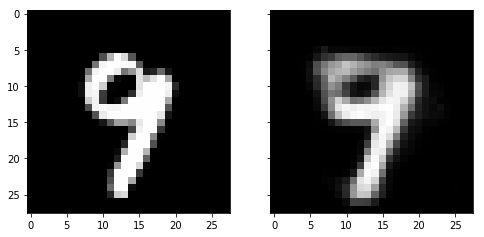

18000 26.368473 15.36325 11.005225


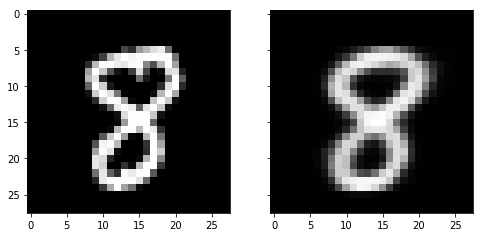

18200 27.540058 15.656394 11.883665


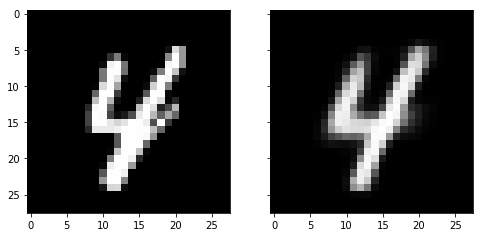

18400 28.078156 16.692862 11.385292


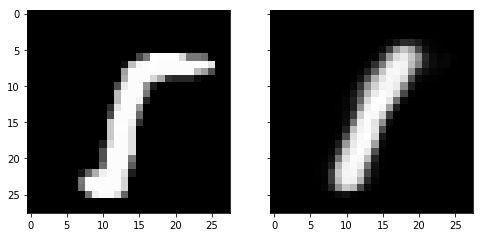

18600 29.200129 17.444317 11.755814


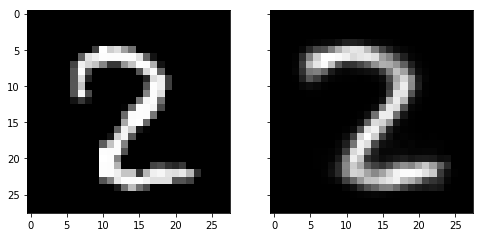

18800 26.225266 14.14819 12.077077


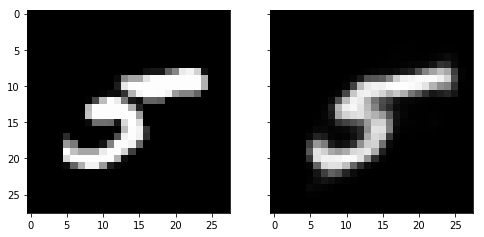

19000 27.481129 15.515062 11.966065


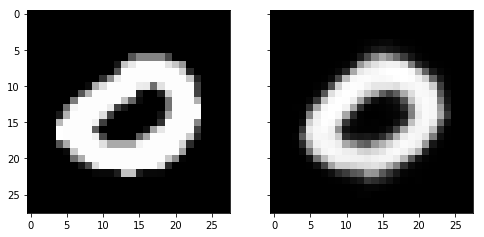

19200 27.76146 15.804567 11.956892


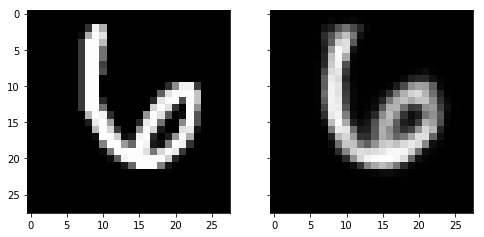

19400 28.205986 16.543924 11.662064


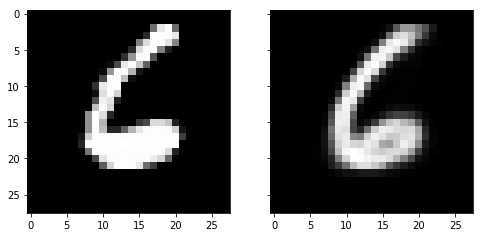

19600 29.775766 17.681452 12.094315


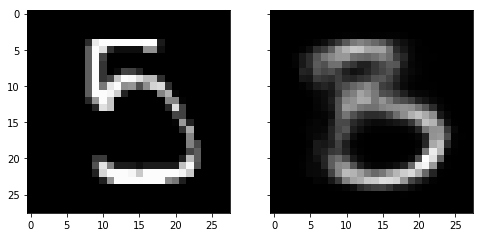

19800 26.57309 14.936663 11.636424


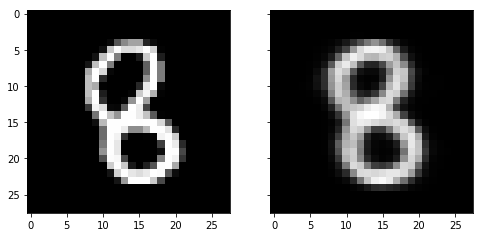

20000 26.50321 15.379807 11.123402


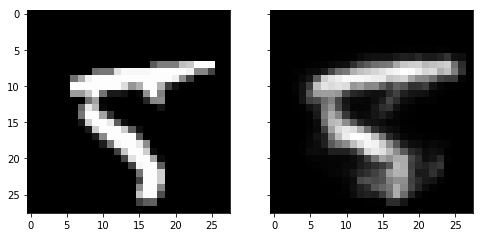

20200 28.292162 15.861809 12.430353


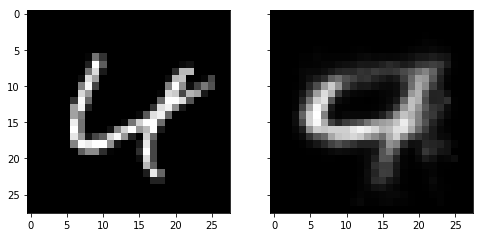

20400 27.508797 15.540742 11.968054


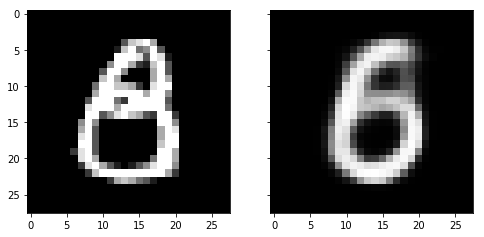

20600 28.108917 16.144495 11.96442


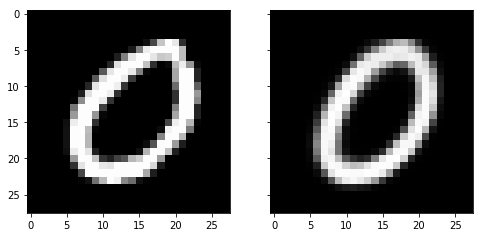

20800 27.181637 15.454962 11.726675


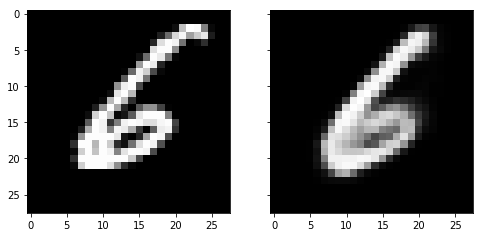

21000 27.867928 16.274925 11.593004


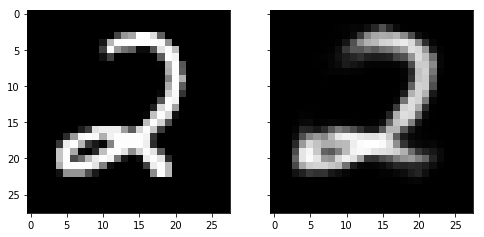

21200 27.232635 15.58182 11.650816


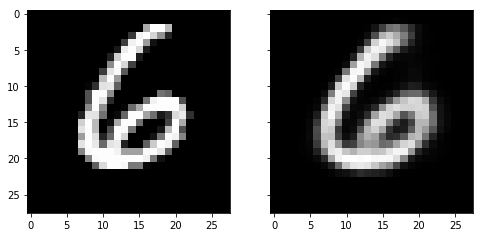

21400 26.464077 15.054402 11.409674


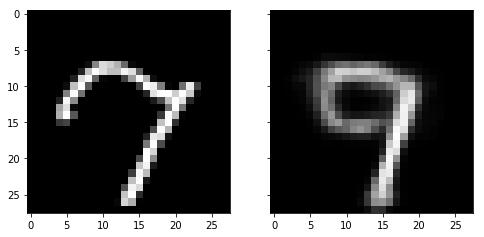

21600 26.552986 15.816167 10.73682


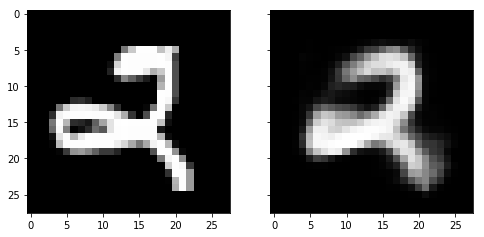

21800 26.807468 14.988364 11.819105


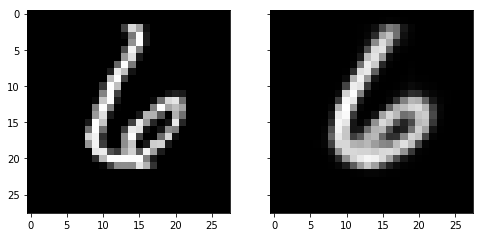

22000 26.336096 14.539569 11.796527


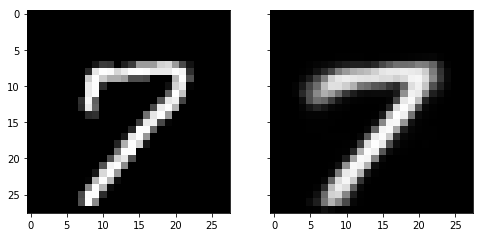

22200 26.535719 14.413691 12.122028


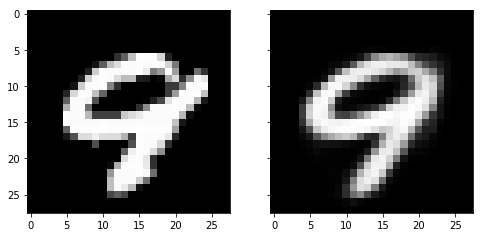

22400 27.18382 15.8067665 11.377054


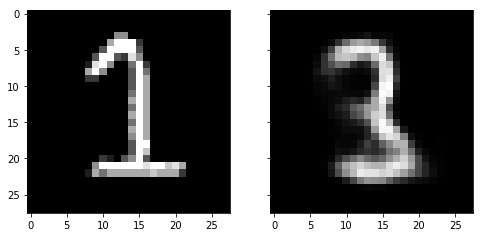

22600 25.93252 14.7008295 11.231689


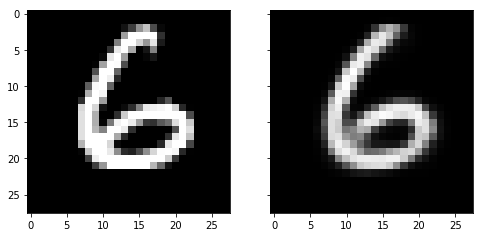

22800 26.365854 14.89296 11.472895


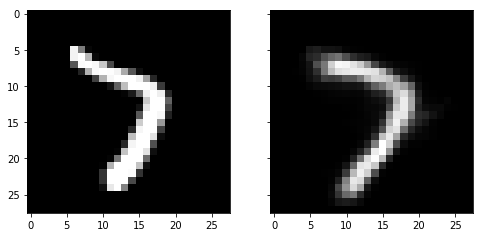

23000 26.508001 14.975545 11.532458


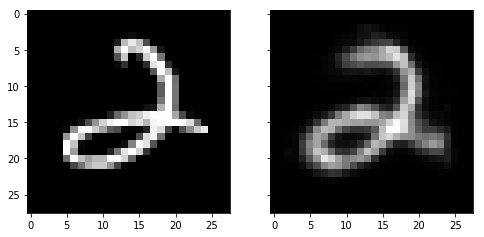

23200 26.250513 14.93417 11.316343


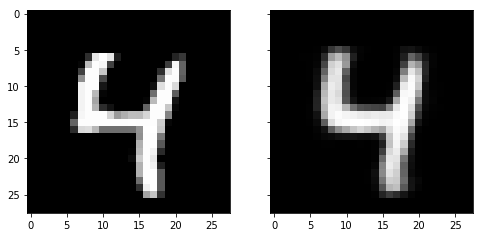

23400 27.512007 15.516062 11.995947


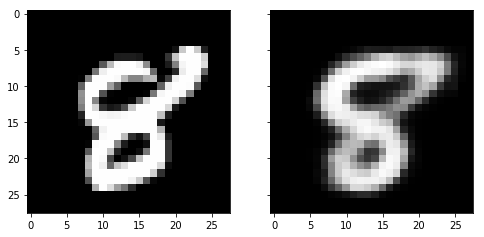

23600 27.32881 15.555507 11.773303


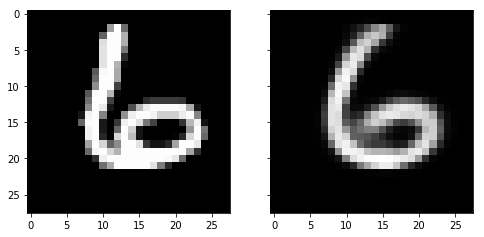

23800 26.374039 14.789809 11.5842285


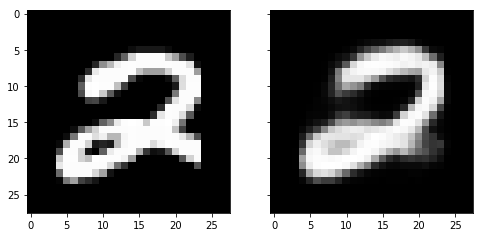

24000 26.312868 14.880146 11.432722


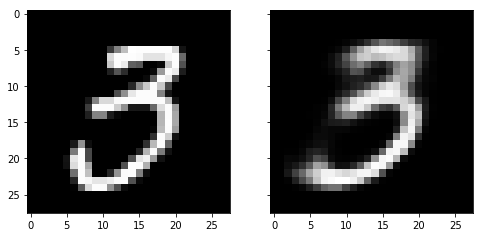

24200 26.034306 14.943043 11.091261


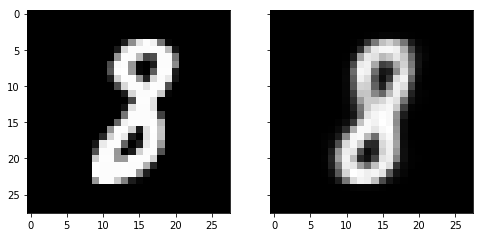

24400 26.959053 15.455926 11.503128


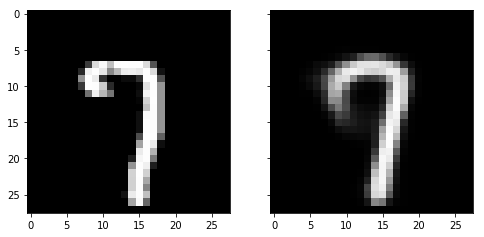

24600 26.75277 15.030556 11.722214


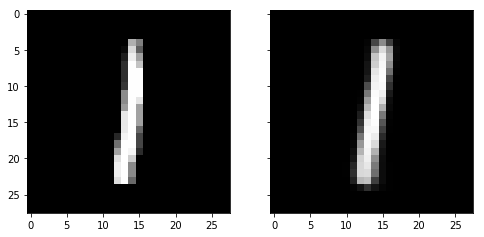

24800 27.835125 15.861999 11.973127


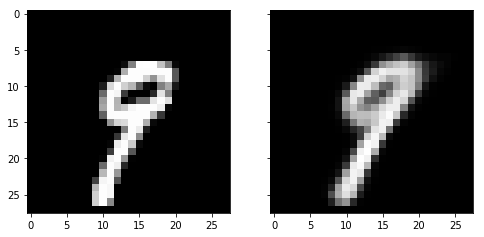

25000 27.485884 15.884214 11.601667


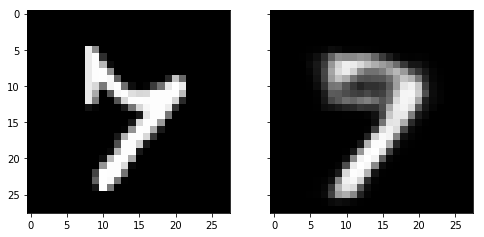

25200 28.536175 16.676727 11.859446


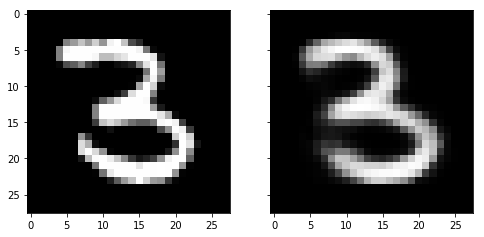

25400 26.802277 14.961344 11.840932


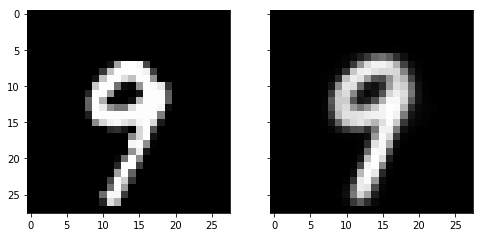

25600 28.231213 16.609566 11.621647


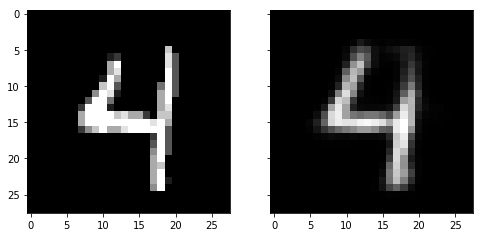

25800 26.689997 15.313002 11.376995


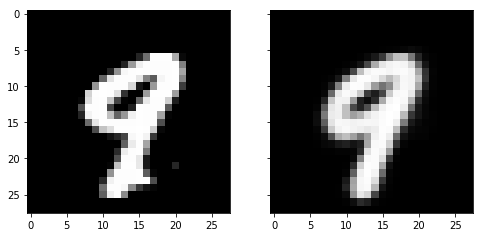

26000 25.990751 14.223629 11.767122


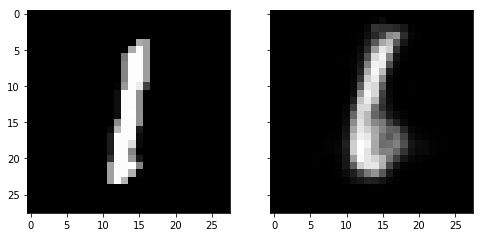

26200 28.230564 15.99408 12.236485


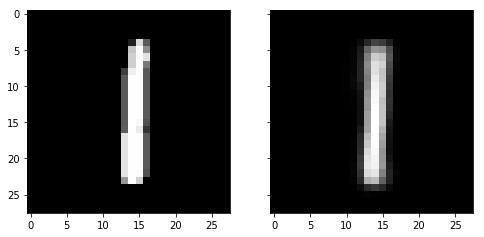

26400 26.581604 14.613382 11.968222


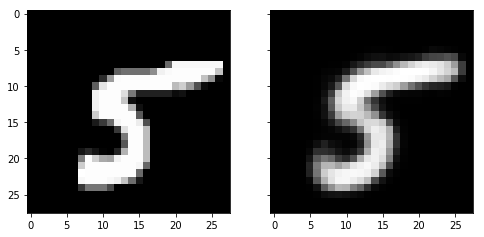

26600 25.011305 13.391262 11.620045


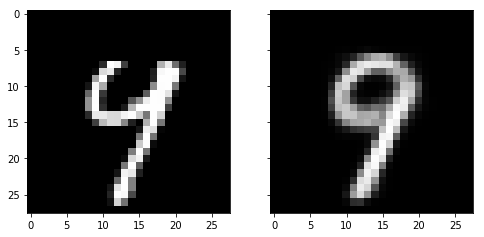

26800 27.049717 15.296071 11.753645


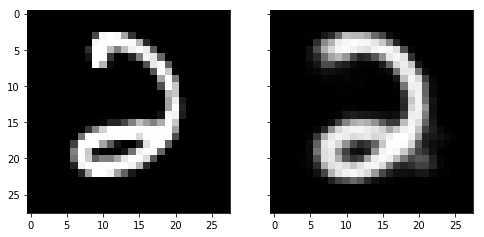

27000 27.049698 14.895696 12.154001


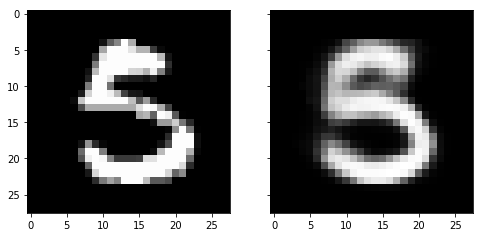

27200 26.428867 15.274904 11.153963


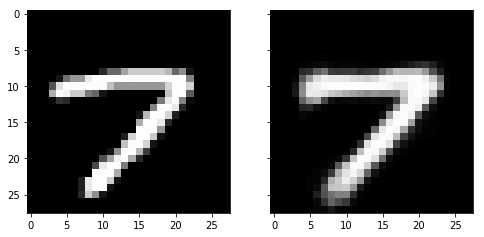

27400 25.717833 14.792685 10.925148


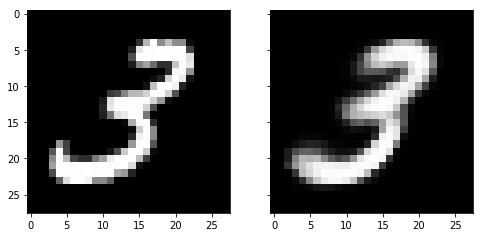

27600 27.300093 14.981884 12.318211


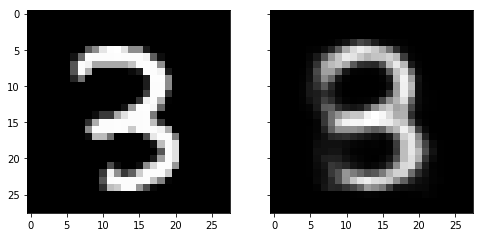

27800 25.65128 14.253128 11.3981495


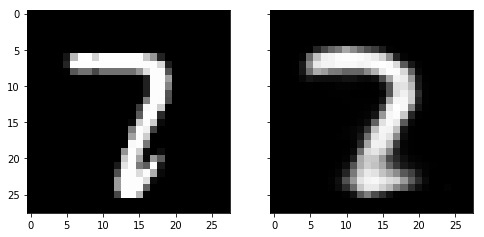

28000 26.6288 14.662962 11.9658375


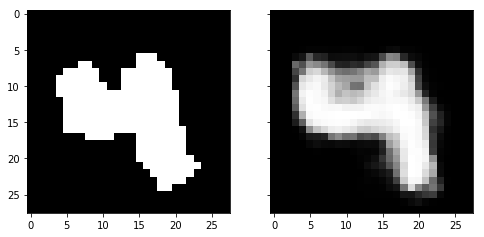

28200 27.01909 15.176607 11.842483


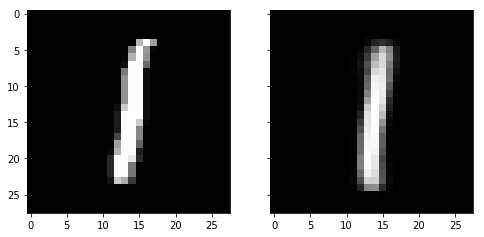

28400 26.431108 14.438398 11.992708


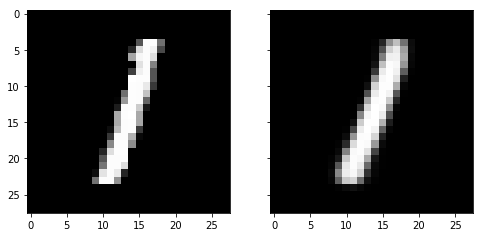

28600 26.37572 14.399841 11.975878


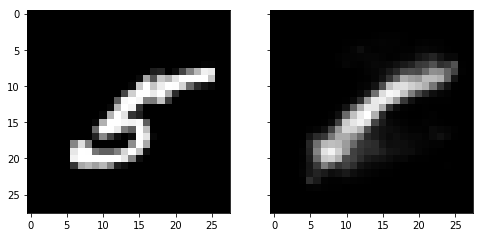

28800 28.132263 16.480751 11.651509


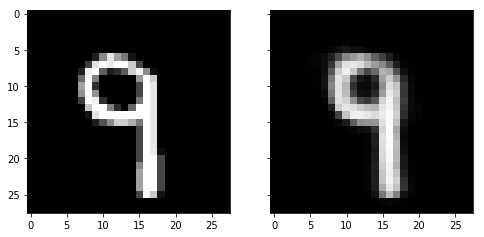

29000 27.201508 15.760756 11.440752


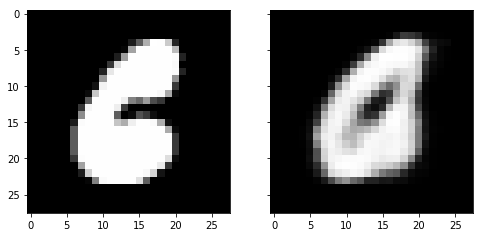

29200 25.980433 14.45537 11.525063


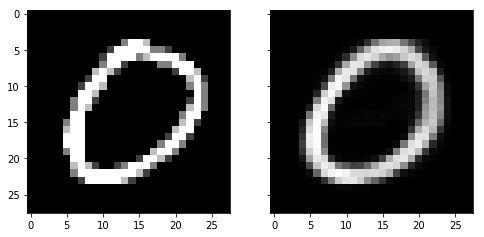

29400 27.489676 15.547161 11.942515


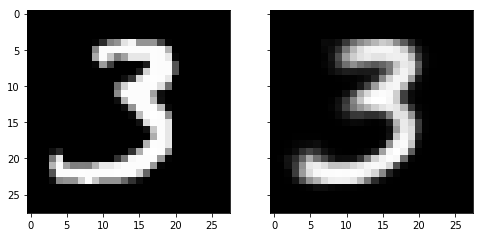

29600 26.644398 15.28171 11.362686


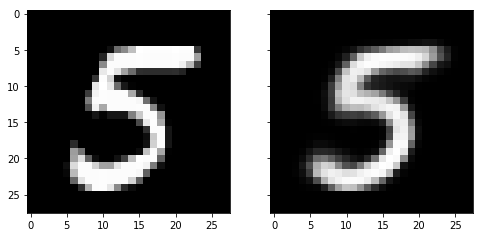

29800 25.585907 13.931047 11.654858


In [11]:
vloss = []
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    l, _ = sess.run([loss, optimizer], feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
    vloss.append(l)
    
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        
        fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(8,12))
        
        axes[0].imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        #plt.show()
        axes[1].imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

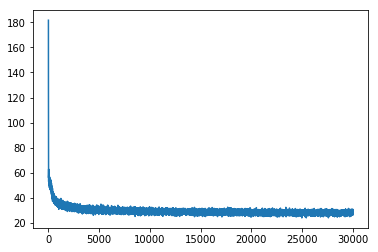

In [12]:
plt.figure()
plt.plot(vloss)

### Generating new data
The most awesome part is that we are now able to create new characters. To this end, we simply sample values from a unit normal distribution and feed them to our decoder. Most of the created characters look just like they've been written by humans.

In [13]:
x1 = np.random.normal(0, 1, n_latent)
print(x1)

[ 3.43743221e-01 -8.48783388e-01 -3.51584438e-01  1.74062526e-03
 -1.41826537e+00  5.31811765e-01 -8.82541480e-02 -5.65929761e-01
  3.23997209e-01 -1.27813540e+00  3.30872245e-01 -2.10338740e+00
  9.86779474e-02 -1.46807894e+00 -6.89403106e-01 -1.48512776e+00]


(array([0.37947796, 0.        , 0.        , 0.75895592, 0.37947796,
        0.37947796, 0.        , 0.37947796, 0.37947796, 0.37947796,
        0.37947796, 0.        , 0.75895592, 0.37947796, 1.13843388,
        0.37947796]),
 array([-2.1033874 , -1.93868745, -1.77398751, -1.60928756, -1.44458761,
        -1.27988766, -1.11518771, -0.95048777, -0.78578782, -0.62108787,
        -0.45638792, -0.29168797, -0.12698803,  0.03771192,  0.20241187,
         0.36711182,  0.53181176]),
 <a list of 16 Patch objects>)

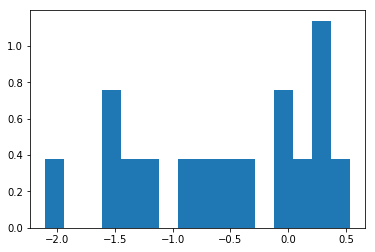

In [14]:
n_bins = n_latent
plt.hist(x1, n_bins, normed=1, histtype='bar')

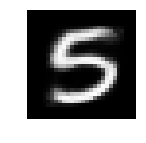

In [15]:
img = sess.run(dec, feed_dict = {sampled: [x1], keep_prob: 1.0})
img = np.reshape(img, [28, 28])
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(img, cmap='gray')

In [16]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
print(np.shape(randoms))

(10, 16)


In [17]:
import os
if not os.path.exists('out'):
    os.makedirs('out')

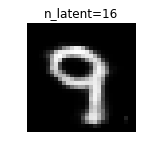

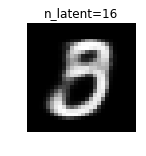

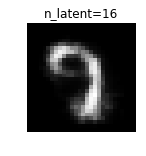

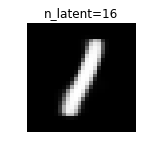

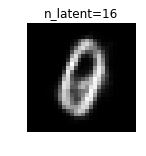

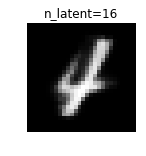

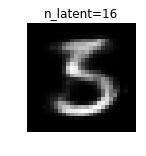

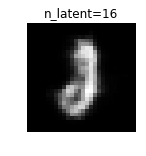

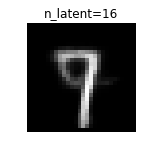

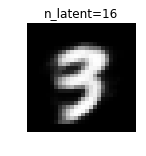

In [18]:
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]
i=0
for img in imgs:
    f1 = plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.title('n_latent={}'.format(n_latent))
    plt.imshow(img, cmap='gray')
    plt.savefig('out/l{}_{}.png'.format(n_latent, i))
    i = i+1

### Just for test

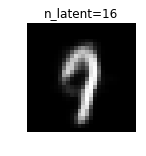

In [19]:
#x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, 0.7, -0.5, -2.5]
x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, -0.7, -0.5, -2.5, 1.2, 1.8, -0.1, 0.7, -0.2, 0.7, -0.5, 0.0]
img = sess.run(dec, feed_dict = {sampled:[x2], keep_prob: 1.0})
img = np.reshape(img, [28, 28])
plt.figure(figsize=(2,2))
plt.axis('off')
plt.title('n_latent={}'.format(n_latent))
plt.imshow(img, cmap='gray')

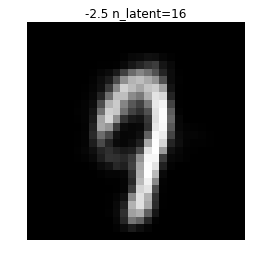

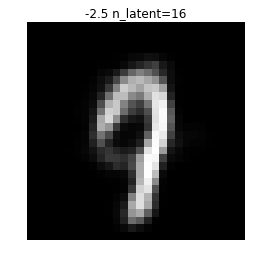

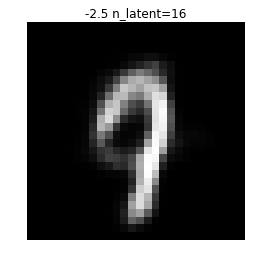

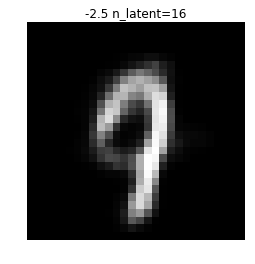

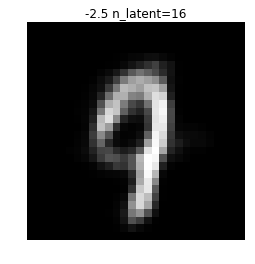

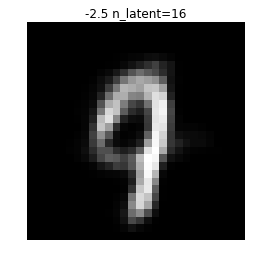

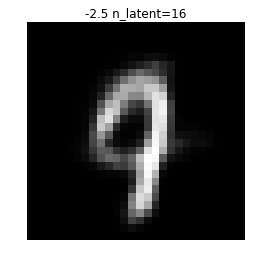

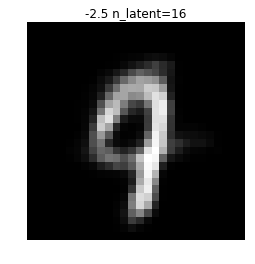

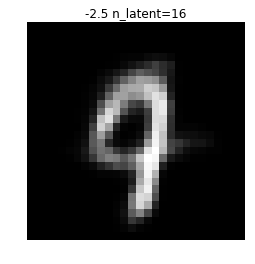

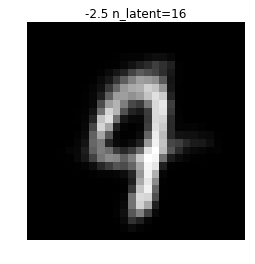

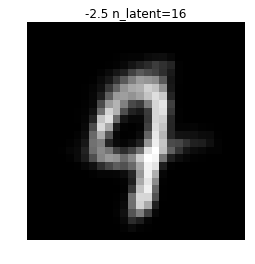

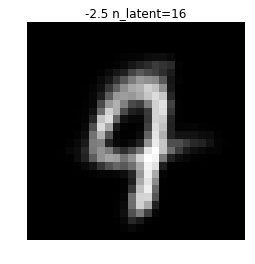

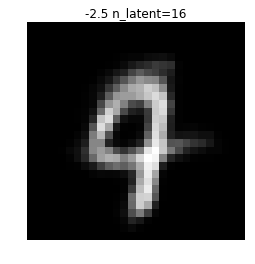

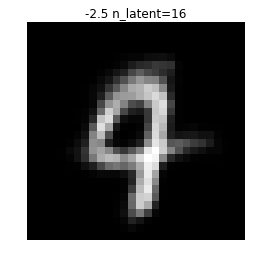

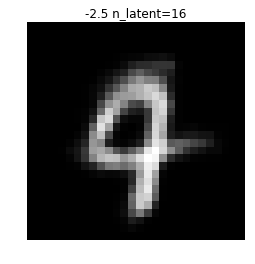

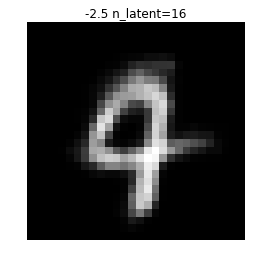

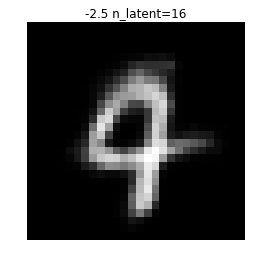

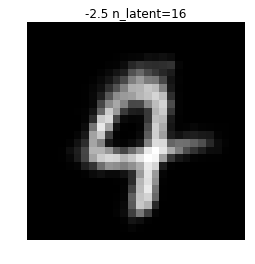

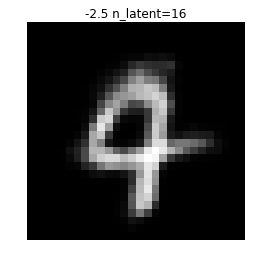

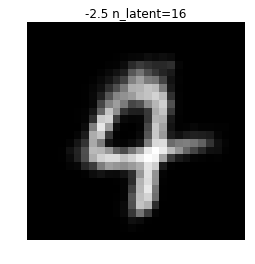

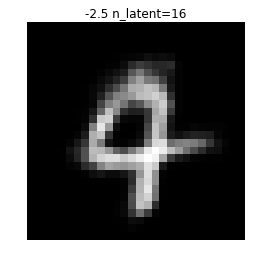

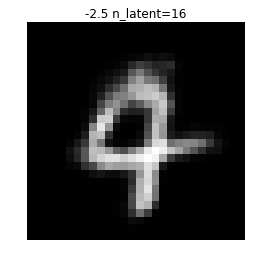

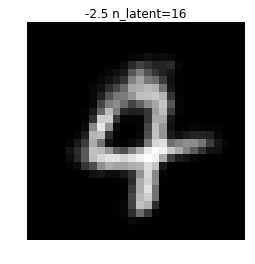

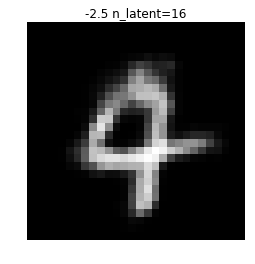

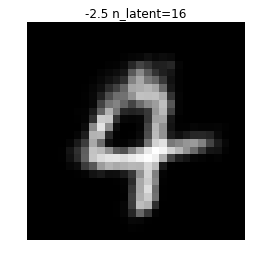

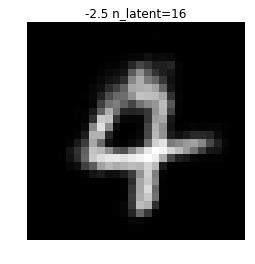

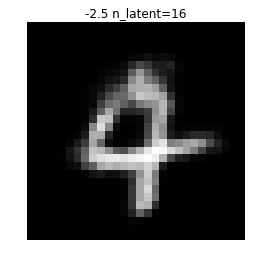

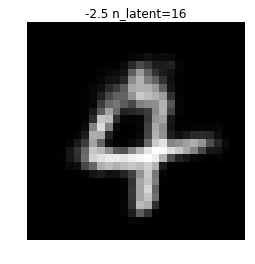

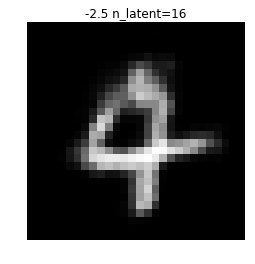

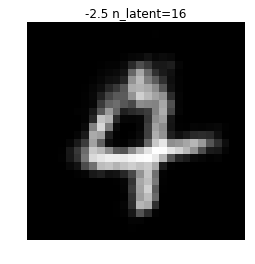

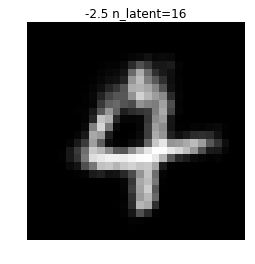

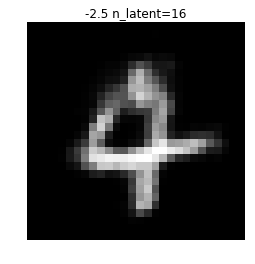

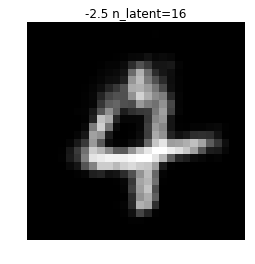

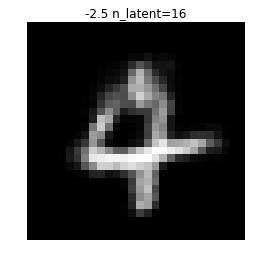

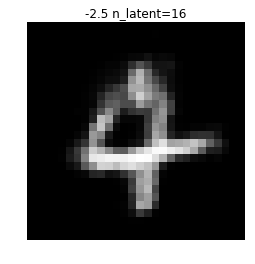

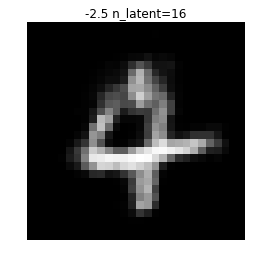

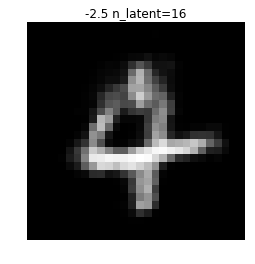

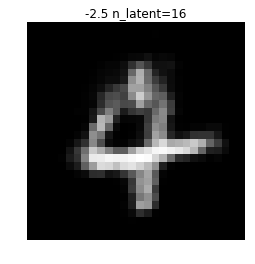

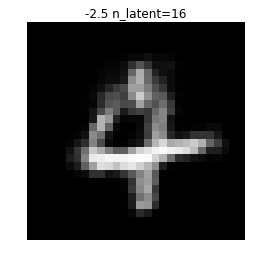

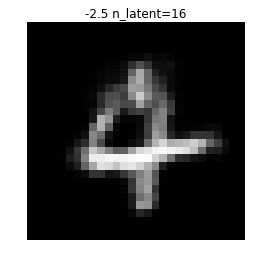

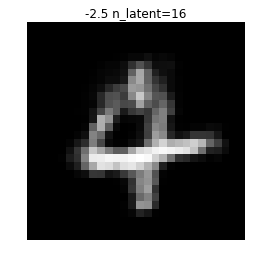

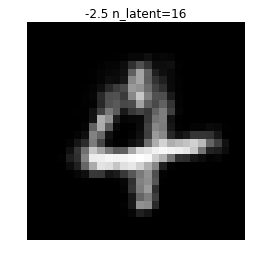

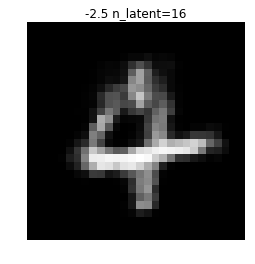

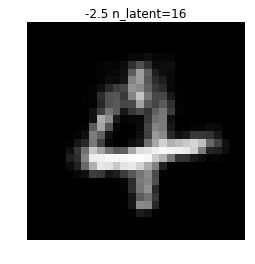

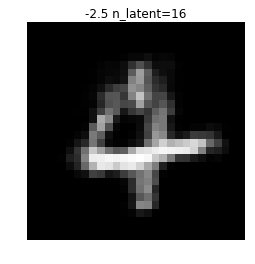

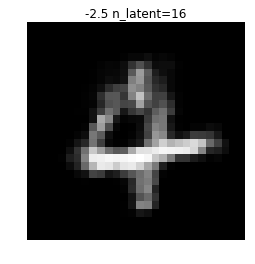

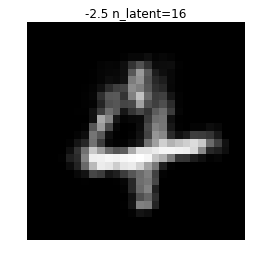

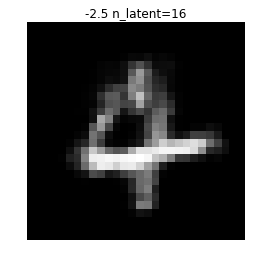

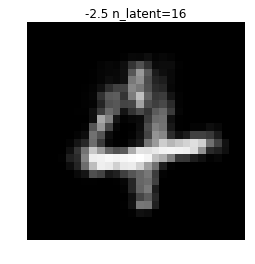

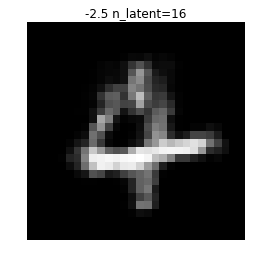

In [22]:
#x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, 0.7, -0.5, -2.5]
x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, -0.7, -0.5, -2.5, 1.2, 1.8, -0.1, 0.7, -0.2, 0.7, -0.5, 0.0]
for i in range(50):
    x2[1] = x2[1]+0.1
    img = sess.run(dec, feed_dict = {sampled:[x2], keep_prob: 1.0})
    img = np.reshape(img, [28, 28])
    plt.figure()
    plt.axis('off')
    plt.title('{} n_latent={}'.format(round(x2[7], 2), n_latent))
    plt.imshow(img, cmap='gray')
    plt.savefig('out/test_l{}_{}.png'.format(n_latent, i))

### References
* https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
* https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/VAE.ipynb